In [1]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

Read saved serialized predictions (see 1vA.ipynb)

In [2]:
with open("results_1vA.pickle", 'rb') as f:
    results = pickle.load(f)
    
datasets = list(results.keys())
datasets


['ajt', 'chd', 'corpas', 'yri']

In [3]:
for test in datasets:
    intersection = np.all([results[test]['preds_lr'], results[test]['preds_ci'], results[test]['preds_xgb']], axis=0)
    results[test]['preds_intersection'] = deepcopy(results[test]['preds_naive'])
    results[test]['preds_intersection'][intersection] = results[test]['preds_xgb'][intersection]

Compute overall accuracies over all datasets and methods

In [4]:
def accuracy(test, pred_type):
    return accuracy_score(results[test]['y_test'],
                          results[test][pred_type])

data = [[accuracy(test, pred_type) for pred_type in ["preds_naive", "preds_ci", "preds_lr", "preds_xgb", "preds_intersection"]] for test in datasets]

df = pd.DataFrame(data, columns=["No recal", "Confidence intervals", "Logistic regression", "XGBoost", "Intersection"])
df['Trio'] = ['chd', 'ajt', 'corpas', 'yri']
df[['Trio', 'No recal', "Confidence intervals", 'Logistic regression', 'XGBoost', "Intersection"]]

,Trio,No recal,Confidence intervals,Logistic regression,XGBoost,Intersection
0,chd,0.876236,0.968708,0.974658,0.983350,0.914397
1,ajt,0.893423,0.925737,0.927396,0.933587,0.911625
2,corpas,0.903020,0.947302,0.951303,0.958145,0.924613
3,yri,0.875756,0.963041,0.970539,0.971130,0.904700


In [5]:
len(results)

4

Plot overall results

In [6]:
contaminations = sorted(list(results['ajt']['idx'].keys()))
pred_types = ['preds_naive',  'preds_ci', 'preds_lr', 'preds_xgb', 'preds_meta'
#              'preds_intersection'
             ]
pred_names = {'preds_naive': "No recalibration",
              'preds_ci': "Confidence interval",
              'preds_lr': "Logistic regression",
              'preds_xgb': "XGBoost",
              'preds_intersection': "Intersection",
              'preds_meta': "Meta-classifier",}

metrics = [precision_score, recall_score, f1_score]
metric_names = ["precision", "recall", "f1"]
metric_desc = ["Precision score", "Recall score", "F1 score"]

scores = {}

for test in datasets:
    scores[test] = {}
    
    for pred_type in pred_types:
        scores[test][pred_type] = {}
        for metric, name in zip(metrics, metric_names):
            scores[test][pred_type][name] = []
            for contamination in contaminations:
                scores[test][pred_type][name].append(metric(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],
                                                            average='macro'))
        scores[test][pred_type]['accuracy'] = []
        for contamination in contaminations:
                scores[test][pred_type]['accuracy'].append(accuracy_score(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],))
metric_names.append('accuracy')

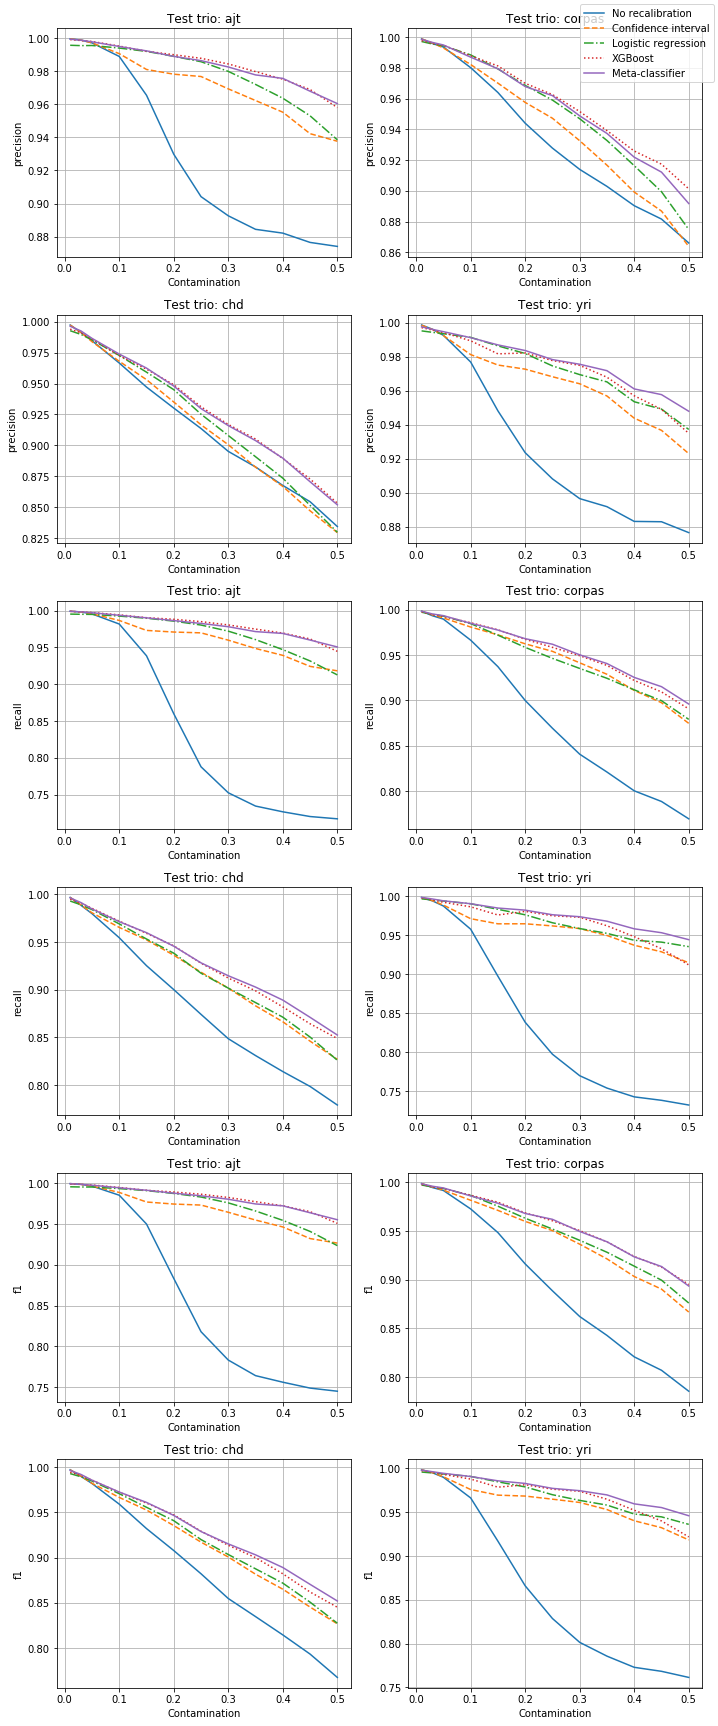

In [7]:
sp, ax = plt.subplots(6, 2, figsize=(10, 24))

linestyles = ['-', '--', '-.', ':', '-']

for j, (metric, name) in enumerate(list(zip(metrics, metric_names))):
    for i, test in enumerate(datasets):
        ax[i%2 + j*2, i//2].set_title("Test trio: {}".format(test))

        for k, pred_type in enumerate(pred_types):
            ax[i%2 + 2*j,i//2].plot(contaminations, scores[test][pred_type][name], label=pred_names[pred_type], linestyle=linestyles[k])


        ax[i%2 +j*2 , i//2].grid()
        ax[i%2 + j*2, i//2].set_xlabel("Contamination")
        ax[i%2 +j*2, i//2].set_ylabel(name)

plt.tight_layout()
handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc='upper right')
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

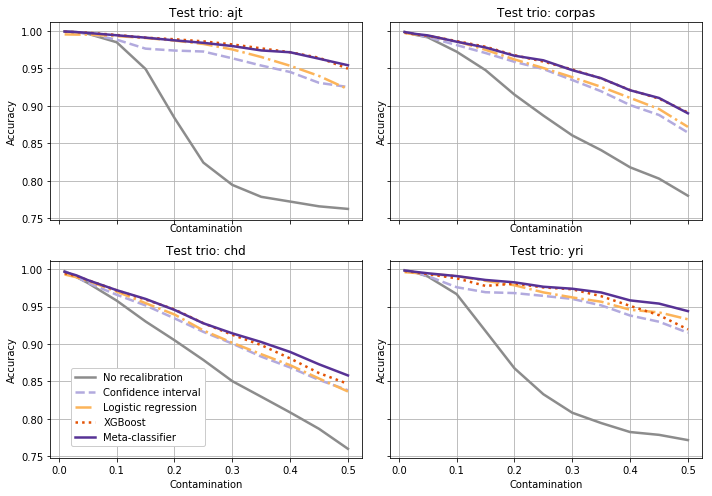

In [48]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

linestyles = ['-', '--', '-.', ':', "-"]
colors = ['#8c8c8c', '#b2aade', '#fcb459', '#e35204', '#573295']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations,
                          [accuracy_score(results[test]['y_test'][results[test]['idx'][c]],
                                          results[test][pred_type][results[test]['idx'][c]]) for c in contaminations],
                          label=pred_names[pred_type], linestyle=linestyles[k], color=colors[k], linewidth=2.5)
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.1, 0.1), prop={'size': 10}, framealpha=1)
plt.tight_layout()
sp.savefig('accuracies.eps', format='eps', dpi=1000)

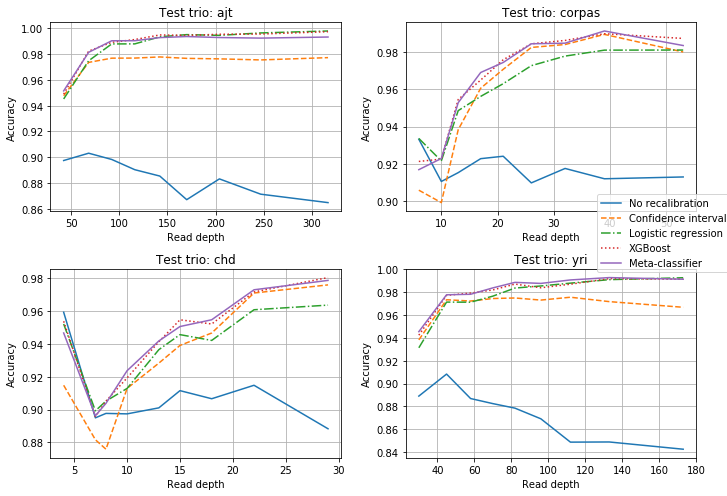

In [9]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7))

linestyles = ['-', '--', '-.', ':', "-", '-']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(edges,
                          [accuracy_score(results[test]['y_test'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])],
                                          results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(9)],
                          label=pred_names[pred_type], linestyle=linestyles[k])
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("Accuracy")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.82, 0.45))
plt.tight_layout()
sp.savefig('accuracies_read_depth.eps', format='eps', dpi=1000)

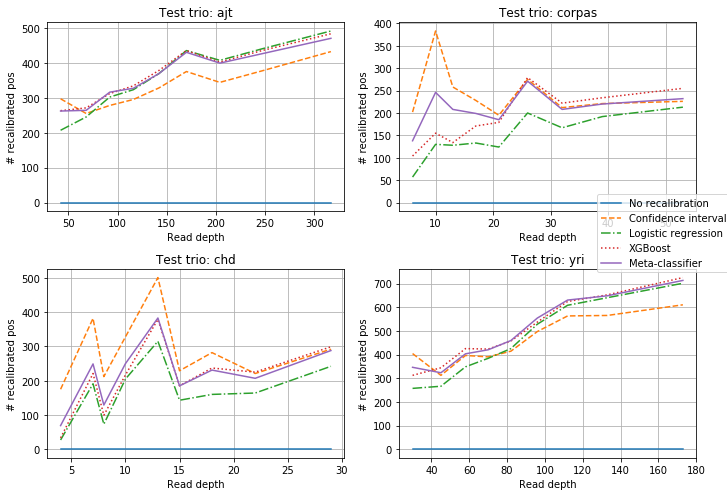

In [10]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7))

linestyles = ['-', '--', '-.', ':', "-"]

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(edges,
                          [np.sum(results[test][pred_type][np.logical_and(bin_idx == i, results[test]['idx'][0.2])] != \
                                  results[test]['preds_naive'][np.logical_and(bin_idx == i, results[test]['idx'][0.2])]) for i in range(9)],
                          label=pred_names[pred_type], linestyle=linestyles[k])
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("# recalibrated pos")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.82, 0.45))
plt.tight_layout()
# sp.savefig('accuracies.eps', format='eps', dpi=1000)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


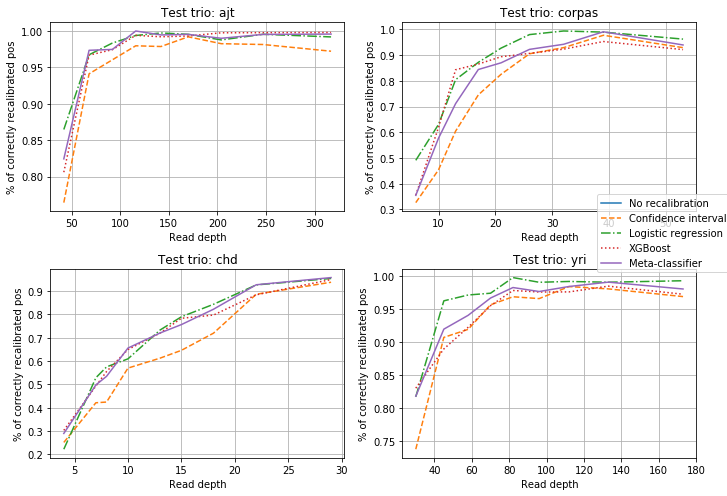

In [11]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7))

linestyles = ['-', '--', '-.', ':', "-"]

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))
    
    edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]
    bin_idx = np.digitize(results[test]['dp'], edges)
    
    
    for k, pred_type in enumerate(pred_types):
        ratios = []
        for bin_id in range(len(edges)):
            af_idx = np.logical_and(bin_idx == bin_id, results[test]['idx'][0.2])
            recal = np.sum(results[test][pred_type][af_idx] != results[test]['preds_naive'][af_idx])
            recal_correct = np.sum(np.logical_and(results[test][pred_type][af_idx] != results[test]['preds_naive'][af_idx],
                                                  results[test][pred_type][af_idx] == results[test]['y_test'][af_idx])
                                            )
            ratios.append(recal_correct/recal)
        
        ax[i%2,i//2].plot(edges,
                          ratios,
                          label=pred_names[pred_type], linestyle=linestyles[k])
    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Read depth")
    ax[i%2, i//2].set_ylabel("% of correctly recalibrated pos")

handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc=(0.82, 0.45))
plt.tight_layout()
sp.savefig('ratio_correct.eps', format='eps', dpi=1000)

In [12]:
edges = [np.percentile(results[test]['dp'], 10*i) for i in range(1,10)]

In [13]:
bin_idx = np.digitize(results[test]['dp'], edges)

(array([48450., 51851., 49703., 48837., 48904., 52921., 50017., 49156.,
        52113., 50230.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

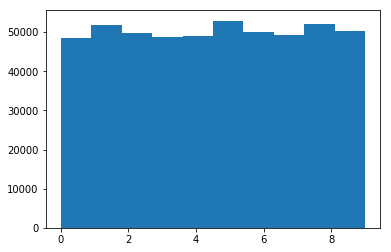

In [14]:
plt.hist(bin_idx)

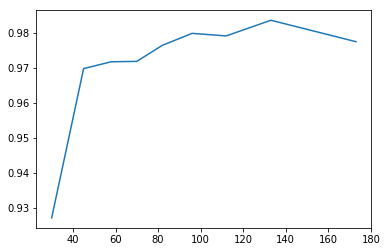

In [15]:
plt.plot(edges,
         [accuracy_score(results[test]['y_test'][bin_idx == i],
                         results[test]['preds_xgb'][bin_idx == i]) for i in range(9)])

In [16]:
edges

[30.0, 45.0, 58.0, 70.0, 82.0, 96.0, 112.0, 133.0, 173.0]